In [19]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer


import matplotlib.pyplot as plt
%config InlineBackend.figure_format='svg'
plt.rcParams.update({
    'text.usetex':False,
    'font.family':'monospace'
})
import seaborn as sns

Bootstrapping to find the confidence interval for AUROC score.

In [20]:
def bootstrap_auc_ci(y_true, y_scores, n_bootstraps=2000, ci=0.95):
    rng = np.random.default_rng(42)
    aucs = []

    y_true = np.array(y_true)
    y_scores = np.array(y_scores)

    for _ in range(n_bootstraps):
        idx = rng.integers(0, len(y_true), len(y_true))
        if len(np.unique(y_true[idx])) < 2:
            continue
        aucs.append(roc_auc_score(y_true[idx], y_scores[idx]))

    lower = np.percentile(aucs, (1 - ci) / 2 * 100)
    upper = np.percentile(aucs, (1 + ci) / 2 * 100)
    return np.mean(aucs), lower, upper

## Loading the dataset, pre-processing, and analysing the data

In [21]:
cohort_data = pd.read_csv('../cohort_data_new.csv')
cohort_data

,icustay_id,anion_gap_mean,anion_gap_sd,anion_gap_min,anion_gap_max,bicarbonate_mean,bicarbonate_sd,bicarbonate_min,bicarbonate_max,calcium_total_mean,...,urea_nitrogen_min,urea_nitrogen_max,white_blood_cells_mean,white_blood_cells_sd,white_blood_cells_min,white_blood_cells_max,age,gender,icu_los_hours,target
0,200003,13.375000,3.583195,9.0,21.0,25.250000,3.105295,18.0,28.0,7.771429,...,10.0,21.0,26.471429,13.176711,13.2,43.9,48,M,141,0
1,200007,15.500000,2.121320,14.0,17.0,23.000000,1.414214,22.0,24.0,8.900000,...,8.0,10.0,10.300000,1.272792,9.4,11.2,44,M,30,0
2,200009,9.500000,2.121320,8.0,11.0,23.333333,2.081666,21.0,25.0,8.000000,...,15.0,21.0,12.471429,1.471637,10.5,14.3,47,F,51,0
3,200012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.900000,NaN,4.9,4.9,33,F,10,0
4,200014,10.000000,1.732051,9.0,12.0,24.000000,1.000000,23.0,25.0,7.733333,...,21.0,24.0,13.233333,2.203028,10.7,14.7,85,M,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30484,299992,15.375000,2.856153,11.0,25.0,23.125000,2.609556,15.0,26.0,8.307143,...,8.0,23.0,14.134783,3.781727,8.1,22.1,41,M,499,0
30485,299993,9.400000,1.341641,8.0,11.0,29.600000,2.073644,26.0,31.0,8.000000,...,12.0,15.0,12.600000,0.605530,12.0,13.3,26,M,67,0
30486,299994,16.157895,2.477973,13.0,24.0,21.631579,3.451417,17.0,31.0,8.100000,...,28.0,63.0,10.076190,2.642329,5.3,14.5,74,F,152,1
30487,299998,11.500000,1.732051,10.0,14.0,23.500000,1.290994,22.0,25.0,8.800000,...,20.0,22.0,9.900000,1.210372,7.9,11.0,87,M,46,1


Simple Imputation to handle the missing values 

In [22]:
lab_cols = [
    'anion_gap_mean', 'anion_gap_min', 'anion_gap_max', 'anion_gap_sd',
    'bicarbonate_mean', 'bicarbonate_min', 'bicarbonate_max', 'bicarbonate_sd',
    'calcium_total_mean', 'calcium_total_min', 'calcium_total_max', 'calcium_total_sd',
    'chloride_mean', 'chloride_min', 'chloride_max', 'chloride_sd',
    'creatinine_mean', 'creatinine_min', 'creatinine_max', 'creatinine_sd',
    'glucose_mean', 'glucose_min', 'glucose_max', 'glucose_sd',
    'hematocrit_mean', 'hematocrit_min', 'hematocrit_max', 'hematocrit_sd',
    'hemoglobin_mean', 'hemoglobin_min', 'hemoglobin_max', 'hemoglobin_sd',
    'mchc_mean', 'mchc_min', 'mchc_max', 'mchc_sd',
    'mcv_mean', 'mcv_min', 'mcv_max', 'mcv_sd',
    'magnesium_mean', 'magnesium_min', 'magnesium_max', 'magnesium_sd',
    'pt_mean', 'pt_min', 'pt_max', 'pt_sd',
    'phosphate_mean', 'phosphate_min', 'phosphate_max', 'phosphate_sd',
    'platelet_count_mean', 'platelet_count_min', 'platelet_count_max', 'platelet_count_sd',
    'potassium_mean', 'potassium_min', 'potassium_max', 'potassium_sd',
    'rdw_mean', 'rdw_min', 'rdw_max', 'rdw_sd',
    'red_blood_cells_mean', 'red_blood_cells_min', 'red_blood_cells_max', 'red_blood_cells_sd',
    'sodium_mean', 'sodium_min', 'sodium_max', 'sodium_sd',
    'urea_nitrogen_mean', 'urea_nitrogen_min', 'urea_nitrogen_max', 'urea_nitrogen_sd',
    'white_blood_cells_mean', 'white_blood_cells_min', 'white_blood_cells_max', 'white_blood_cells_sd',
    'age', 'icu_los_hours'
]

target_col = 'target'

df = cohort_data.copy()
df = df.drop('icustay_id', axis=1)
df = df.drop('gender', axis=1)

X = df.drop(columns=[target_col])
y = df[target_col]

print("Final shape:", X.shape)

Final shape: (30489, 90)


In [23]:
print(df.info())        
print(df.describe())    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30489 entries, 0 to 30488
Data columns (total 91 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   anion_gap_mean          29956 non-null  float64
 1   anion_gap_sd            23225 non-null  float64
 2   anion_gap_min           29956 non-null  float64
 3   anion_gap_max           29956 non-null  float64
 4   bicarbonate_mean        30235 non-null  float64
 5   bicarbonate_sd          24683 non-null  float64
 6   bicarbonate_min         30235 non-null  float64
 7   bicarbonate_max         30235 non-null  float64
 8   calcium_total_mean      27008 non-null  float64
 9   calcium_total_sd        20100 non-null  float64
 10  calcium_total_min       27008 non-null  float64
 11  calcium_total_max       27008 non-null  float64
 12  chloride_mean           30237 non-null  float64
 13  chloride_sd             24790 non-null  float64
 14  chloride_min            30237 non-null

In [24]:
dataset = np.array(df)
y = np.array(df['target'])
X = np.array(df.drop('target', axis=1))
print(np.shape(dataset))
print(np.shape(X))
print(np.shape(y))

# Random shuffle and split 70-30 into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7, shuffle=True)

imputer = SimpleImputer(strategy="median")
X_train = imputer.fit_transform(X_train)   # fit on training only
X_test  = imputer.transform(X_test)        # transform test using train params


print(np.shape(X_train))
print(np.shape(X_test))
print(np.shape(y_train))
print(np.shape(y_test))

print(f'# Readmissions in Train: {np.sum(y_train)}')
print(f'# Readmissions in Test: {np.sum(y_test) }')
print(f'% Readmissions in Train: {np.mean(y_train) * 100}')
print(f'% Readmissions in Test: {np.mean(y_test) * 100}')

(30489, 91)
(30489, 90)
(30489,)
(21342, 90)
(9147, 90)
(21342,)
(9147,)
# Readmissions in Train: 2294
# Readmissions in Test: 982
% Readmissions in Train: 10.748758316933746
% Readmissions in Test: 10.735760358587514


In [25]:
# Training the LR 
model = LogisticRegression(max_iter=500_000)
model.fit(X_train, y_train)

c:\Users\risha\miniconda3\envs\ML_Torch\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=500000)

In [26]:
# Calculate training error for the vanilla Logistic Regression model
y_train_pred = model.predict(X_train)
train_error = np.mean(y_train_pred != y_train)
print(f"Training error (Vanilla LR): {train_error:.3f}")

# Calculate test error for the vanilla Logistic Regression model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]
test_error = np.mean(y_pred != y_test)
print(f"Test error (Vanilla LR): {test_error:.3f}")

Training error (Vanilla LR): 0.108
Test error (Vanilla LR): 0.108


Classification Report:

                    precision    recall  f1-score   support

No Readmission (0)       0.89      1.00      0.94      8165
   Readmission (1)       0.38      0.01      0.03       982

          accuracy                           0.89      9147
         macro avg       0.64      0.51      0.48      9147
      weighted avg       0.84      0.89      0.84      9147

AUROC for class 1 (Readmission): 0.685
95% CI = [0.6672, 0.7039]


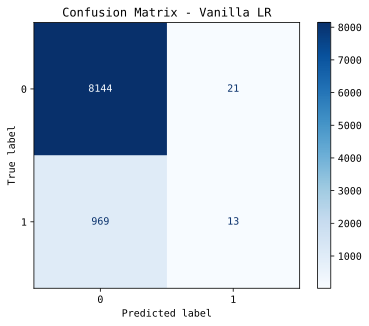

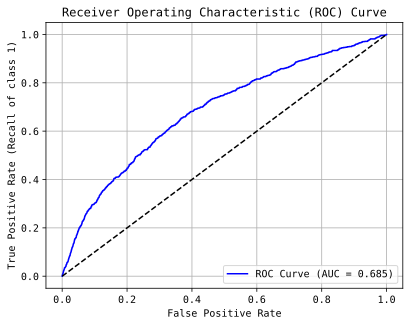

In [27]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Vanilla LR")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=["No Readmission (0)", "Readmission (1)"]))
_, lower, upper = bootstrap_auc_ci(y_test, y_pred_proba)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba, pos_label=1)
roc_auc = auc(fpr, tpr)
np.savez('../results/lr_imputation_fpr_tpr_thresholds.npz', fpr, tpr, thresholds)
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--') 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall of class 1)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
print(f"AUROC for class 1 (Readmission): {roc_auc:.3f}")
print(f"95% CI = [{lower:.4f}, {upper:.4f}]")